# kNN/Gradient-Boosted Trees


In [9]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
data = "hf://datasets/jsburner/6be9adb1-3efe-4f31-97ad-1b30c79d20d2-imdb/"
df_full = pd.read_parquet(data + "plain_text/train-00000-of-00001.parquet")

In [10]:
train_df, val_df = train_test_split(
    df_full,
    test_size=0.25,
    random_state=42,
    stratify=df_full["label"],
)
X_train_text = train_df["text"]
y_train = train_df["label"].values
X_val_text = val_df["text"]
y_val = val_df["label"].values
tfidf = TfidfVectorizer(lowercase=True, stop_words="english", max_features=50_000, ngram_range=(1,2))
X_train = tfidf.fit_transform(train_df["text"])
X_val = tfidf.transform(val_df["text"])
y_train = train_df["label"].values
y_val = val_df["label"].values

In [11]:
knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X_train, y_train)
knn_train = accuracy_score(y_train, knn.predict(X_train))
knn_val = accuracy_score(y_val,   knn.predict(X_val))
print(f"kNN accuracy – train: {knn_train:.3f} | val: {knn_val:.3f}")

kNN accuracy – train: 0.836 | val: 0.761


In [12]:
gbt = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary:logistic", n_jobs=-1,
    eval_metric="logloss", tree_method="hist"
).fit(X_train, y_train)
gbt_train = accuracy_score(y_train, gbt.predict(X_train))
gbt_val = accuracy_score(y_val,   gbt.predict(X_val))
print(f"GBT accuracy – train: {gbt_train:.3f} | val: {gbt_val:.3f}")

GBT accuracy – train: 0.924 | val: 0.845


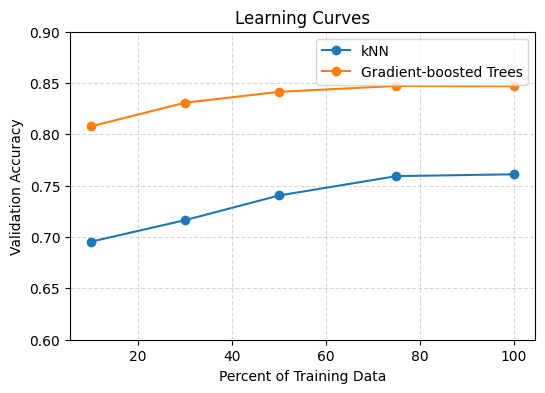

In [13]:
fractions = [0.1, 0.3, 0.5, 0.75, 1.0]
acc_knn_curve, acc_xgb_curve = [], []
for frac in fractions:
    sub_idx = np.random.choice(X_train.shape[0], int(frac*X_train.shape[0]), replace=False)
    X_sub, y_sub = X_train[sub_idx], y_train[sub_idx]
    knn_tmp = KNeighborsClassifier(n_neighbors=7, metric='cosine').fit(X_sub, y_sub)
    acc_knn_curve.append(accuracy_score(y_val, knn_tmp.predict(X_val)))
    xgb_tmp = XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.05,
                            subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', n_jobs=-1,
                            eval_metric='logloss', tree_method='hist').fit(X_sub, y_sub)
    acc_xgb_curve.append(accuracy_score(y_val, xgb_tmp.predict(X_val)))
plt.figure(figsize=(6,4))
plt.plot([int(f*100) for f in fractions], acc_knn_curve, marker='o', label='kNN')
plt.plot([int(f*100) for f in fractions], acc_xgb_curve, marker='o', label='Gradient-boosted Trees')
plt.xlabel('Percent of Training Data'); plt.ylabel('Validation Accuracy')
plt.title('Learning Curves'); plt.ylim(0.6,0.9); plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


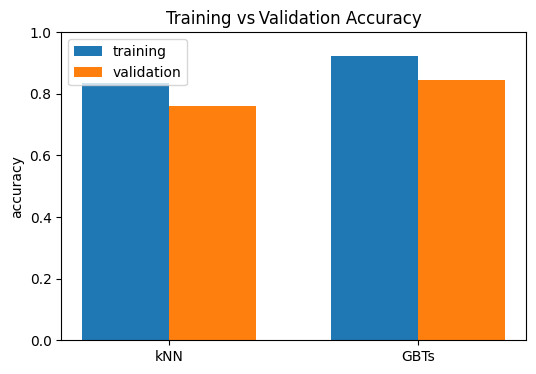

In [17]:
labels = ["kNN", "GBTs"]
train_acc = [acc_knn_train, acc_xgb_train]
val_acc = [acc_knn_val,  acc_xgb_val]
x = np.arange(len(labels)); width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - width/2, train_acc, width=width, label="training")
plt.bar(x + width/2, val_acc,   width=width, label="validation")
plt.ylabel("accuracy"); plt.ylim(0,1)
plt.xticks(x, labels)
plt.title("Training vs Validation Accuracy")
plt.legend(); plt.show()

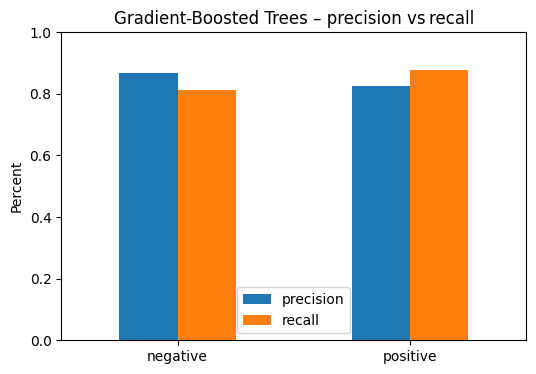

In [20]:
precision_and_recall = classification_report(y_val, xgb.predict(X_val), target_names=["negative","positive"], output_dict=True)
df_metrics = (
    pd.DataFrame(precision_and_recall)
      .transpose()
      .loc[["negative","positive"], ["precision","recall"]]
)
df_metrics.plot(kind="bar", figsize=(6,4))
plt.ylabel("Percent"); plt.ylim(0,1)
plt.title("Gradient-Boosted Trees – precision vs recall")
plt.xticks(rotation=0)
plt.show()
